# Segurança em Redes de COmunicações - Project 2

## 1. Introduction

The objective of this work is to define SIEM rules to detect anomalous behavior on the network, identify potentially compromised devices, and justify all rules based on real traffic data. The work is carried out in Python, using Pandas for analyzing Parquet files and GeoLite2 for geolocation.


In [2]:
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import geoip2.database
import matplotlib.pyplot as plt 

## 2. Analysis of non-anomalous behaviors

### 2.1. Identification of network private IPv4 network(s)

Detected Private Network(s): ['192.168.108']

Flow count by private network:
network_prefix
192.168.108    868432

Source IP addresses (all) for network 192.168.108:
src_ip
192.168.108.98     10567
192.168.108.86     10196
192.168.108.15      9973
192.168.108.176     9655
192.168.108.45      9461
192.168.108.29      9367
192.168.108.131     9356
192.168.108.52      9136
192.168.108.87      9062
192.168.108.136     8881
192.168.108.58      8679
192.168.108.210     8641
192.168.108.30      8062
192.168.108.151     8022
192.168.108.16      7930
192.168.108.203     7706
192.168.108.197     7433
192.168.108.187     7373
192.168.108.71      7354
192.168.108.167     7346
192.168.108.139     7313
192.168.108.204     7240
192.168.108.57      7237
192.168.108.39      7231
192.168.108.148     7149
192.168.108.195     7143
192.168.108.85      7027
192.168.108.130     7001
192.168.108.95      6878
192.168.108.140     6852
192.168.108.207     6832
192.168.108.88      6828
192.168.108.121     6812
19

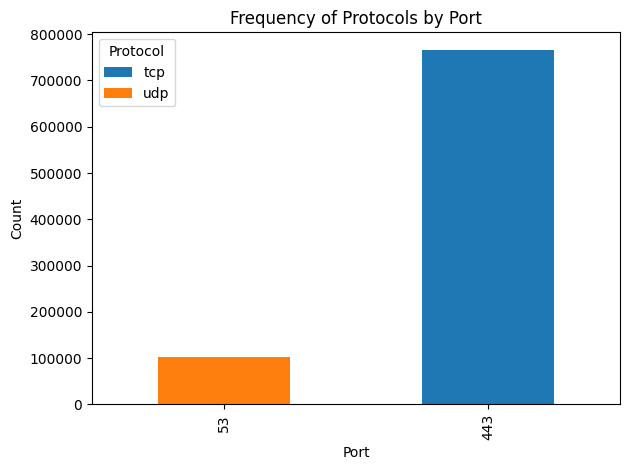

In [3]:
DATAFILE = '../dataset8/data8.parquet'
data = pd.read_parquet(DATAFILE)

# Filter flows based on private source IPs
private_ips_mask = data['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)
data_private = data.loc[private_ips_mask].copy()

# Extract the network prefix (first three octets) that normally identifies the private network
data_private['network_prefix'] = data_private['src_ip'].apply(lambda ip: '.'.join(ip.split('.')[:3]))

# List unique private networks and their flow counts
private_networks = data_private['network_prefix'].unique()
print("Detected Private Network(s):", private_networks)

network_counts = data_private['network_prefix'].value_counts()
print("\nFlow count by private network:")
print(network_counts.to_string())

# Loop through each private network to display detailed info
for net in private_networks:
    subset = data_private[data_private['network_prefix'] == net]
    
    # Display all source IP addresses and their counts
    ip_counts = subset['src_ip'].value_counts()
    print("\nSource IP addresses (all) for network {}:".format(net))
    print(ip_counts.to_string())
    
    # Display complete protocol distribution, if available
    if 'proto' in subset.columns:
        protocol_counts = subset['proto'].value_counts()
        print("\nProtocols used (all) for network {}:".format(net))
        print(protocol_counts.to_string())
    else:
        print("\nProtocol information not available for network {}.".format(net))
    
    # Display complete ports used and their counts, if available
    if 'port' in subset.columns:
        port_counts = subset['port'].value_counts().sort_index()
        print("\nPorts used (all) for network {}:".format(net))
        print(port_counts.to_string())
    else:
        print("\nPort information not available for network {}.".format(net))

# Create a stacked bar chart: frequency of protocols by port
protocol_port_counts = data.groupby(['port', 'proto']).size().unstack(fill_value=0)
protocol_port_counts.plot(kind='bar', stacked=True)
plt.title("Frequency of Protocols by Port")
plt.xlabel("Port")
plt.ylabel("Count")
plt.legend(title="Protocol")
plt.tight_layout()
plt.show()

### 2.2. Identification of internal server/services

Total internal destination flows: 255173

Internal server/service candidates (by flow count):
dst_ip
192.168.108.234    51465
192.168.108.240    51417
192.168.108.233    51371
192.168.108.231    50596
192.168.108.237    50324

Details for internal server/service 192.168.108.234:
  Ports used:
port
443    51465
  Protocols used:
proto
tcp    51465

Details for internal server/service 192.168.108.240:
  Ports used:
port
53    51417
  Protocols used:
proto
udp    51417

Details for internal server/service 192.168.108.233:
  Ports used:
port
53    51371
  Protocols used:
proto
udp    51371

Details for internal server/service 192.168.108.231:
  Ports used:
port
443    50596
  Protocols used:
proto
tcp    50596

Details for internal server/service 192.168.108.237:
  Ports used:
port
443    50324
  Protocols used:
proto
tcp    50324


<Figure size 1200x600 with 0 Axes>

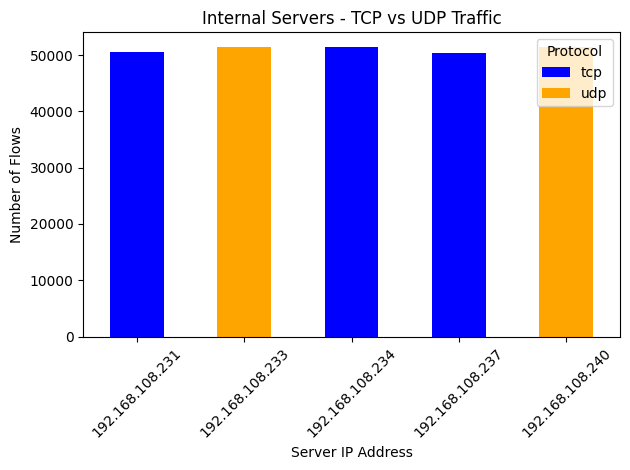

In [4]:
# Identify internal servers/services:
# Filter flows where the destination IP is private
internal_dst_mask = data['dst_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)
data_internal = data.loc[internal_dst_mask].copy()

print("Total internal destination flows:", len(data_internal))

# Group by destination IP to see which internal servers/services are most active
server_flow_counts = data_internal['dst_ip'].value_counts()
print("\nInternal server/service candidates (by flow count):")
print(server_flow_counts.to_string())

# For each candidate internal server, show additional details
for server in server_flow_counts.index:
    server_data = data_internal[data_internal['dst_ip'] == server]
    port_counts = server_data['port'].value_counts().sort_index() if 'port' in server_data.columns else None
    proto_counts = server_data['proto'].value_counts() if 'proto' in server_data.columns else None
    
    print(f"\nDetails for internal server/service {server}:")
    if port_counts is not None:
        print("  Ports used:")
        print(port_counts.to_string())
    else:
        print("  Port information not available.")
        
    if proto_counts is not None:
        print("  Protocols used:")
        print(proto_counts.to_string())
    else:
        print("  Protocol information not available.")

# Create a visualization of internal servers by protocol (TCP vs UDP)
plt.figure(figsize=(12, 6))

# Get top N servers by flow count for better visualization
top_n = 10
top_servers = server_flow_counts.head(top_n).index.tolist()

# Filter data for only the top servers
top_servers_data = data_internal[data_internal['dst_ip'].isin(top_servers)]

# Group by destination IP and protocol, then count
protocol_counts = top_servers_data.groupby(['dst_ip', 'proto']).size().unstack(fill_value=0)

# Create the stacked bar chart
protocol_counts.plot(kind='bar', stacked=True, color=['blue', 'orange'])
plt.title(f'Internal Servers - TCP vs UDP Traffic')
plt.xlabel('Server IP Address')
plt.ylabel('Number of Flows')
plt.xticks(rotation=45)
plt.legend(title='Protocol')
plt.tight_layout()
plt.show()

### 2.3. Internal and External Traffic Statistics

Internal -> Internal Traffic:
  Total flows: 255173
  Total Upload: 1755598820 bytes
  Total Download: 16137426802 bytes
  Upload/Download Ratio: 0.11

Internal -> External Traffic:
  Total flows: 613259
  Total Upload: 6983350023 bytes
  Total Download: 64657801901 bytes
  Upload/Download Ratio: 0.11

Destination Countries for Internal -> External Traffic (Percentage):
dst_country
US    49.359783
PT    41.069176
NL     3.059121
DE     2.834443
GB     1.507610
ES     0.728107
BR     0.672785
IE     0.206119
HK     0.078700
IN     0.070669
AU     0.053359
IT     0.045150
SG     0.040331
KR     0.036048
CA     0.033550
SE     0.029802
JP     0.029089
ZA     0.022843
FR     0.020701
CH     0.020166
BH     0.017310
IL     0.013741
AE     0.013384
SA     0.009101
NO     0.006424
CN     0.005532
BE     0.005175
ID     0.003391
MY     0.002141
NZ     0.001606
TH     0.001249
DK     0.000892
CL     0.000892
TW     0.000714
OM     0.000535
FI     0.000357


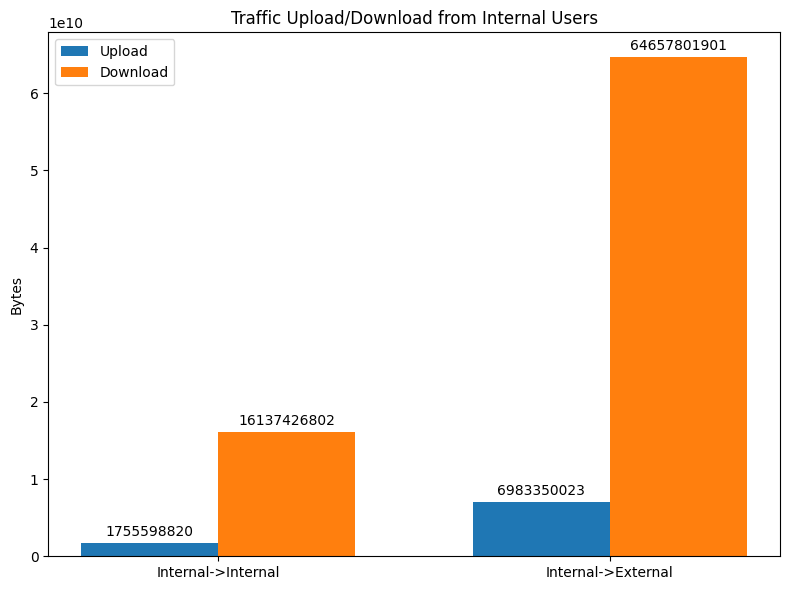

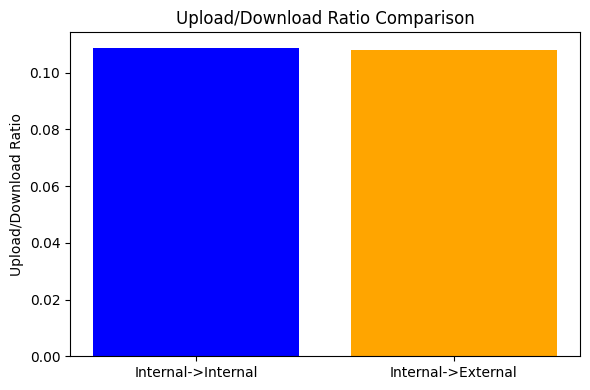

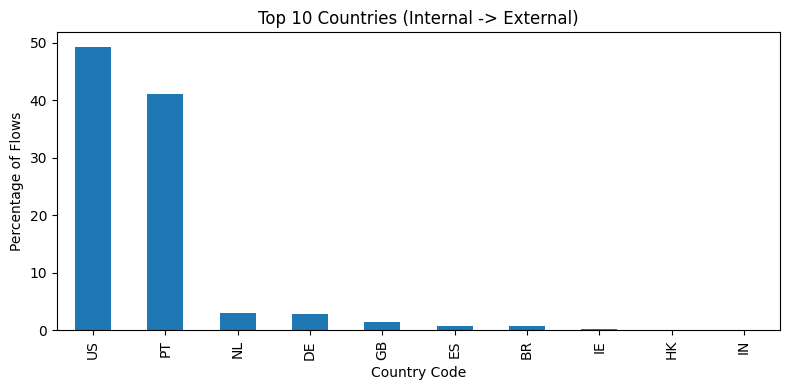

In [5]:
# Mark internal (private) sources and destinations
data['src_priv'] = data['src_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)
data['dst_priv'] = data['dst_ip'].apply(lambda x: ipaddress.ip_address(x).is_private)

# Internal -> Internal traffic: both src and dst are private
flows_internal = data[(data['src_priv']) & (data['dst_priv'])].copy()

# Internal -> External traffic: source is private, destination is public
flows_external = data[(data['src_priv']) & (~data['dst_priv'])].copy()

# Function to compute overall statistics
def compute_stats(servers):
    total_flows = len(servers)
    total_upload = servers['up_bytes'].sum()
    total_download = servers['down_bytes'].sum()
    ratio = total_upload/total_download if total_download else np.nan
    return total_flows, total_upload, total_download, ratio

flows_in_stats = compute_stats(flows_internal)
flows_ex_stats = compute_stats(flows_external)

print("Internal -> Internal Traffic:")
print(f"  Total flows: {flows_in_stats[0]}")
print(f"  Total Upload: {flows_in_stats[1]} bytes")
print(f"  Total Download: {flows_in_stats[2]} bytes")
print(f"  Upload/Download Ratio: {flows_in_stats[3]:.2f}")

print("\nInternal -> External Traffic:")
print(f"  Total flows: {flows_ex_stats[0]}")
print(f"  Total Upload: {flows_ex_stats[1]} bytes")
print(f"  Total Download: {flows_ex_stats[2]} bytes")
print(f"  Upload/Download Ratio: {flows_ex_stats[3]:.2f}")

# For external traffic, determine destination countries using GeoLite2
geoCC = geoip2.database.Reader('../GeoLite2/GeoLite2-Country.mmdb')

def get_country(ip):
    try:
        return geoCC.country(ip).country.iso_code
    except Exception:
        return 'XX'

flows_external['dst_country'] = flows_external['dst_ip'].apply(get_country)
country_pct = flows_external['dst_country'].value_counts(normalize=True) * 100

print("\nDestination Countries for Internal -> External Traffic (Percentage):")
print(country_pct.to_string())

# Plotting Upload/Download bytes for both traffic types
import matplotlib.pyplot as plt
import numpy as np

categories = ['Internal->Internal', 'Internal->External']
upload_values = [flows_in_stats[1], flows_ex_stats[1]]
download_values = [flows_in_stats[2], flows_ex_stats[2]]

x = np.arange(len(categories))
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, upload_values, width, label='Upload')
rects2 = ax.bar(x + width/2, download_values, width, label='Download')

ax.set_ylabel('Bytes')
ax.set_title('Traffic Upload/Download from Internal Users')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{int(height)}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plotting the Upload/Download ratio for both traffic categories
ratios = [flows_in_stats[3], flows_ex_stats[3]]
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(categories, ratios, color=['blue','orange'])
ax.set_ylabel('Upload/Download Ratio')
ax.set_title('Upload/Download Ratio Comparison')
plt.tight_layout()
plt.show()

country_pct.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Countries (Internal -> External)")
plt.xlabel("Country Code")
plt.ylabel("Percentage of Flows")
plt.tight_layout()
plt.show()

### 2.4. Upload/Download Statistics, Ratios, and Destination Countries

Total external IPs: 195
Total flows: 733439
Total unique internal servers accessed: 2
Average flows per external IP: 3761.225641025641
Average interval between flows (s): 7.776958406751367
Median upload/download ratio: 0.11759739108998508


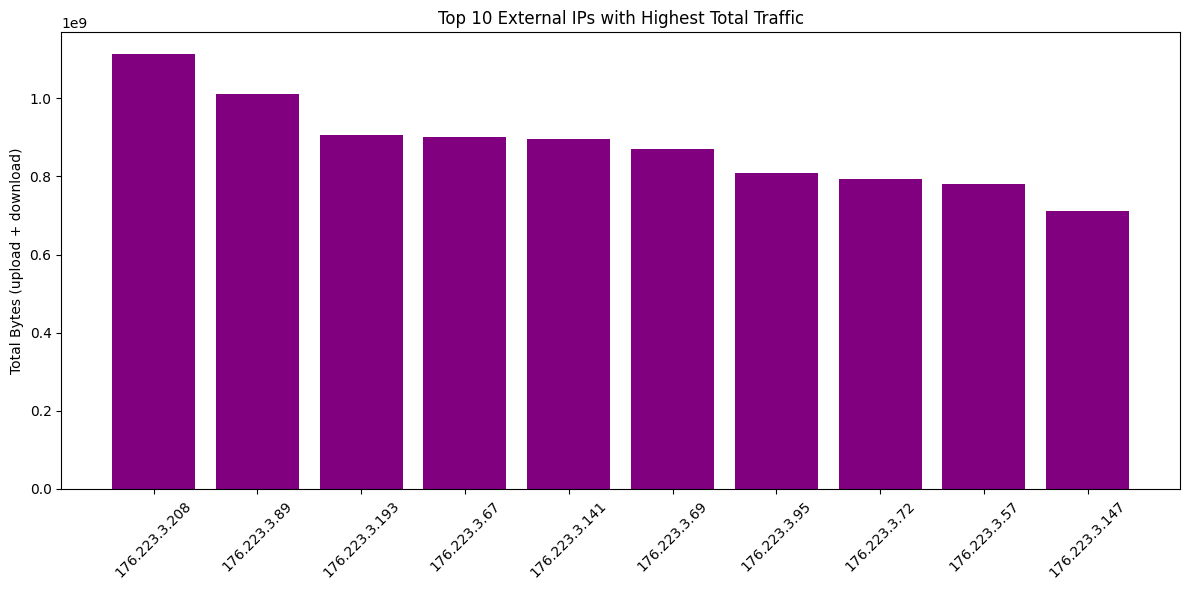

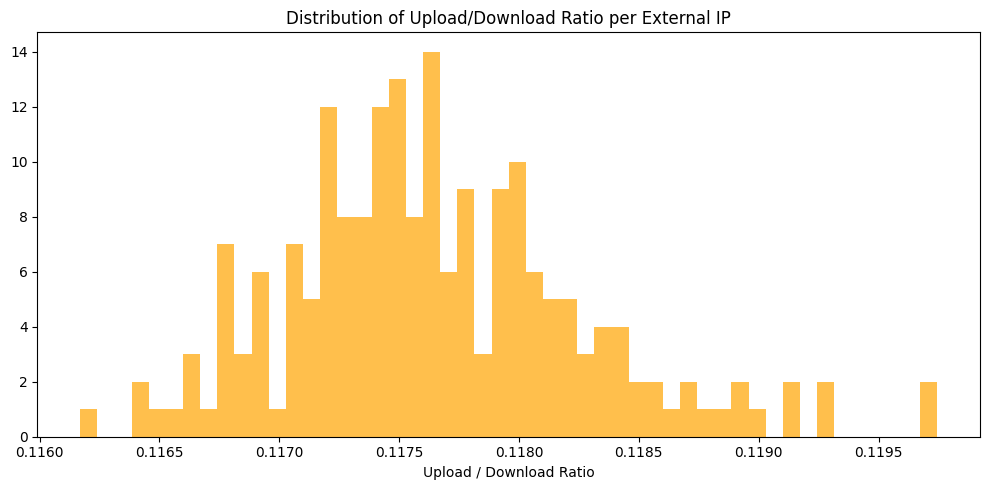

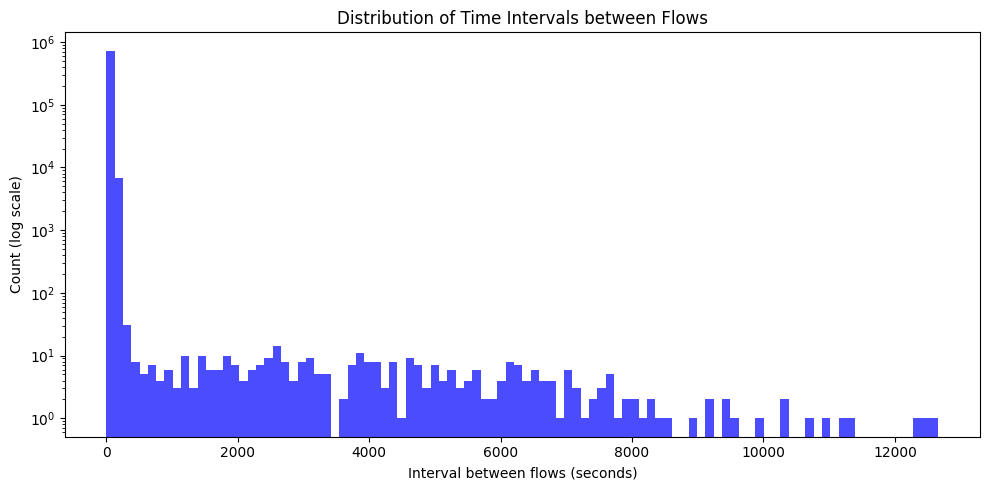

In [6]:
SERVERSFILE = '../dataset8/servers8.parquet'
servers = pd.read_parquet(SERVERSFILE)

# Convert timestamp from centésimos to seconds
servers['timestamp'] = servers['timestamp'] / 100.0

# Compute traffic summary by external source (src_ip)
traffic_summary = servers.groupby('src_ip').agg({
    'dst_ip': 'nunique',      # unique destination servers accessed
    'up_bytes': 'sum',
    'down_bytes': 'sum',
    'timestamp': 'count'
}).rename(columns={
    'dst_ip': 'unique_dst_servers',
    'timestamp': 'num_flows'
})

# Calculate upload/download ratio (adding 1 to denominator to avoid division by zero)
traffic_summary['upload_download_ratio'] = traffic_summary['up_bytes'] / (traffic_summary['down_bytes'] + 1)
traffic_summary['total_traffic'] = traffic_summary['up_bytes'] + traffic_summary['down_bytes']

# Identify top 10 external IPs with more total traffic
top_ips = traffic_summary.sort_values(by='total_traffic', ascending=False).head(10)

# Calculate the time interval between successive flows per external IP
servers = servers.sort_values(by=['src_ip', 'timestamp'])
servers['time_diff'] = servers.groupby('src_ip')['timestamp'].diff()

print("Total external IPs:", traffic_summary.shape[0])
print("Total flows:", servers.shape[0])
print("Total unique internal servers accessed:", servers['dst_ip'].nunique())
print("Average flows per external IP:", traffic_summary['num_flows'].mean())
print("Average interval between flows (s):", servers['time_diff'].mean())
print("Median upload/download ratio:", traffic_summary['upload_download_ratio'].median())

# Plot Top 10 external IPs by total traffic (upload + download)
plt.figure(figsize=(12, 6))
plt.bar(top_ips.index, top_ips['total_traffic'], color='purple')
plt.xticks(rotation=45)
plt.title('Top 10 External IPs with Highest Total Traffic')
plt.ylabel('Total Bytes (upload + download)')
plt.tight_layout()
plt.show()

# Plot distribution of upload/download ratio per external IP
plt.figure(figsize=(10, 5))
plt.hist(traffic_summary['upload_download_ratio'], bins=50, color='orange', alpha=0.7)
plt.title('Distribution of Upload/Download Ratio per External IP')
plt.xlabel('Upload / Download Ratio')
plt.tight_layout()
plt.show()

# Plot distribution of time intervals between flows
plt.figure(figsize=(10, 5))
plt.hist(servers['time_diff'].dropna(), bins=100, log=True, color='blue', alpha=0.7)
plt.title('Distribution of Time Intervals between Flows')
plt.xlabel('Interval between flows (seconds)')
plt.ylabel('Count (log scale)')
plt.tight_layout()
plt.show()

## 3. SIEM Rules

### 3.1. Rule 1

In [7]:
# Consider only internal devices (private source IPs)
normal_internal = data[data['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()

# Compute baseline statistics per internal device
normal_stat = normal_internal.groupby('src_ip').agg(
    flows=('src_ip', 'count'),
    unique_dst=('dst_ip', pd.Series.nunique)
).reset_index()

# Calculate overall baseline averages
mean_flows = normal_stat['flows'].mean()
mean_unique_dst = normal_stat['unique_dst'].mean()
print("Baseline Mean Flows per device:", mean_flows)
print("Baseline Mean Unique Destinations per device:", mean_unique_dst)

# Define threshold multipliers (tuned based on the baseline)
FLOW_MULTIPLIER = 2
UNIQUE_DST_MULTIPLIER = 2

# Load test data (which may include BotNet activity)
test = pd.read_parquet('../dataset8/test8.parquet')
test_internal = test[test['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()

# Group test flows by internal device
test_stat = test_internal.groupby('src_ip').agg(
    flows=('src_ip', 'count'),
    unique_dst=('dst_ip', pd.Series.nunique)
).reset_index()

# Detect potential BotNet devices in test data:
anomalous_devices = test_stat[
    (test_stat['flows'] > FLOW_MULTIPLIER * mean_flows) &
    (test_stat['unique_dst'] > UNIQUE_DST_MULTIPLIER * mean_unique_dst)
]

if not anomalous_devices.empty:
    print("Alert: Possible internal BotNet activity detected for devices:")
    print(anomalous_devices.to_string(index=False))
else:
    print("No potential BotNet activity detected in test data.")

Baseline Mean Flows per device: 4408.284263959391
Baseline Mean Unique Destinations per device: 122.00507614213198
Alert: Possible internal BotNet activity detected for devices:
         src_ip  flows  unique_dst
192.168.108.150  12332         267
192.168.108.166  13976         295


### 3.2. Rule 2

In [8]:
# Consider only internal devices (private source IPs)
normal_internal = data[data['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()

# HTTPS flows (typically port 443)
normal_https = normal_internal[normal_internal['port'] == 443]
normal_https_stat = normal_https.groupby('src_ip')['up_bytes'].sum().reset_index(name='https_up_bytes')
avg_https_up = normal_https_stat['https_up_bytes'].mean()
print("Baseline average HTTPS upload (bytes) per device:", avg_https_up)

# DNS flows (typically port 53, can be TCP or UDP)
normal_dns = normal_internal[normal_internal['port'] == 53]
normal_dns_stat = normal_dns.groupby('src_ip')['up_bytes'].sum().reset_index(name='dns_up_bytes')
avg_dns_up = normal_dns_stat['dns_up_bytes'].mean()
print("Baseline average DNS upload (bytes) per device:", avg_dns_up)

# Define threshold multipliers (tuned based on the baseline)
HTTPS_MULTIPLIER = 3   # e.g. 3 times the baseline for HTTPS
DNS_MULTIPLIER = 3     # e.g. 3 times the baseline for DNS

# --- Test: load test data and compute per-device HTTPS and DNS upload volumes ---
test = pd.read_parquet('../dataset8/test8.parquet')
test_internal = test[test['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()

# HTTPS flows in test data
test_https = test_internal[test_internal['port'] == 443]
test_https_stat = test_https.groupby('src_ip')['up_bytes'].sum().reset_index(name='https_up_bytes')

# DNS flows in test data
test_dns = test_internal[test_internal['port'] == 53]
test_dns_stat = test_dns.groupby('src_ip')['up_bytes'].sum().reset_index(name='dns_up_bytes')

# Identify devices with anomalously high HTTPS upload (potential exfiltration)
suspicious_https = test_https_stat[test_https_stat['https_up_bytes'] > (HTTPS_MULTIPLIER * avg_https_up)]
if not suspicious_https.empty:
    print("Alert: Devices with anomalous HTTPS upload (possible data exfiltration):")
    print(suspicious_https.to_string(index=False))
else:
    print("No anomalous HTTPS activity detected in test data.")

# Identify devices with anomalously high DNS upload (possible data exfiltration)
suspicious_dns = test_dns_stat[test_dns_stat['dns_up_bytes'] > (DNS_MULTIPLIER * avg_dns_up)]
if not suspicious_dns.empty:
    print("Alert: Devices with anomalous DNS upload (possible data exfiltration):")
    print(suspicious_dns.to_string(index=False))
else:
    print("No anomalous DNS activity detected in test data.")

Baseline average HTTPS upload (bytes) per device: 44255878.68020304
Baseline average DNS upload (bytes) per device: 104267.730964467
Alert: Devices with anomalous HTTPS upload (possible data exfiltration):
         src_ip  https_up_bytes
192.168.108.146      7377582576
192.168.108.166       139733278
192.168.108.185      3014261217
Alert: Devices with anomalous DNS upload (possible data exfiltration):
         src_ip  dns_up_bytes
192.168.108.113       7965362
192.168.108.165       4640677
192.168.108.166        342120
 192.168.108.19        412066
192.168.108.200       9059720


### 3.3. Rule 3

In [9]:
normal_internal = data[data['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()

# Filter DNS flows (typically port 53)
normal_dns = normal_internal[normal_internal['port'] == 53]

# Count the number of DNS flows per internal device in baseline data
normal_dns_count = normal_dns.groupby('src_ip').size().reset_index(name='dns_flow_count')
avg_dns_flows = normal_dns_count['dns_flow_count'].mean()
print("Baseline average DNS flows per device:", avg_dns_flows)

# Calculate baseline timing statistics for DNS flows
normal_dns_sorted = normal_dns.sort_values(by=['src_ip', 'timestamp'])
normal_dns_sorted['time_diff'] = normal_dns_sorted.groupby('src_ip')['timestamp'].diff()
normal_dns_time = normal_dns_sorted.groupby('src_ip')['time_diff'].agg(['mean', 'std']).reset_index()
normal_dns_time.rename(columns={'mean': 'avg_time_diff', 'std': 'std_time_diff'}, inplace=True)

# Filter to include only devices with at least 3 DNS flows (needed for meaningful time diff stats)
normal_dns_time = normal_dns_time[normal_dns_time['avg_time_diff'].notna()]
baseline_avg_time = normal_dns_time['avg_time_diff'].mean()
baseline_std_time = normal_dns_time['std_time_diff'].mean()

print("Baseline average time between DNS flows (seconds):", baseline_avg_time)
print("Baseline average std dev of time between DNS flows:", baseline_std_time)

# Threshold multipliers
DNS_FLOW_MULTIPLIER = 3
TIME_DIFF_FACTOR = 0.1  # For detecting unusually regular timing (beaconing)

# --- Test data analysis ---
test = pd.read_parquet('../dataset8/test8.parquet')
test_internal = test[test['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()

# Filter DNS flows (port 53) in test data
test_dns = test_internal[test_internal['port'] == 53]

# Count the number of DNS flows per internal device in test data
test_dns_count = test_dns.groupby('src_ip').size().reset_index(name='dns_flow_count')

# Compute time interval statistics between DNS flows
test_dns_sorted = test_dns.sort_values(by=['src_ip', 'timestamp'])
test_dns_sorted['time_diff'] = test_dns_sorted.groupby('src_ip')['timestamp'].diff()
test_dns_time = test_dns_sorted.groupby('src_ip')['time_diff'].agg(['mean', 'std']).reset_index()
test_dns_time.rename(columns={'mean': 'avg_time_diff', 'std': 'std_time_diff'}, inplace=True)

# Merge count and timing statistics
test_dns_stats = pd.merge(test_dns_count, test_dns_time, on='src_ip', how='left')

# Flag devices with anomalous DNS behavior:
# 1. High number of DNS flows OR
# 2. Unusually regular timing (low std_time_diff) suggesting beaconing behavior
suspicious_dns_cc = test_dns_stats[
    (test_dns_stats['dns_flow_count'] > (DNS_FLOW_MULTIPLIER * avg_dns_flows)) | 
    ((test_dns_stats['std_time_diff'].notna()) & 
     (test_dns_stats['std_time_diff'] < TIME_DIFF_FACTOR * baseline_std_time) &
     (test_dns_stats['dns_flow_count'] >= 5))  # Require at least 5 flows for timing analysis
]

if not suspicious_dns_cc.empty:
    print("Alert: Devices with potential C&C activity using DNS detected:")
    print(suspicious_dns_cc.to_string(index=False))
else:
    print("No potential C&C activity using DNS detected in test data.")

Baseline average DNS flows per device: 521.7664974619289
Baseline average time between DNS flows (seconds): 5686.096974651809
Baseline average std dev of time between DNS flows: 29689.190979754778
Alert: Devices with potential C&C activity using DNS detected:
         src_ip  dns_flow_count  avg_time_diff  std_time_diff
192.168.108.113           39682      72.096822    1082.566673
192.168.108.165           23195      67.465465     863.255413
192.168.108.166            1729    3560.768519    6513.552670
 192.168.108.19            2052    1549.226719    3871.843407
192.168.108.200           45315      64.405327     384.004009


### 3.4. Rule 4


Baseline external destinations per internal device:
Total internal devices in baseline: 197
Average number of external destinations per device: 117.02


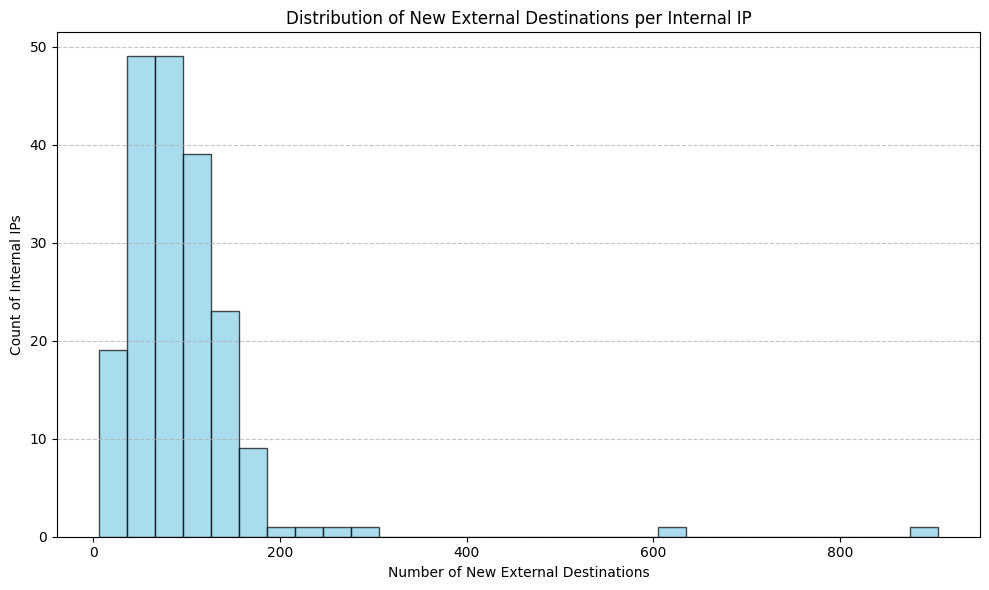

Alert: Devices with anomalous external destinations detected:
         src_ip  n_new                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [12]:
normal_external = data[(data['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)) &
                       (~data['dst_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private))].copy()

baseline_dest = normal_external.groupby('src_ip')['dst_ip'].agg(lambda x: set(x)).reset_index()
baseline_dest.rename(columns={'dst_ip': 'baseline_dsts'}, inplace=True)

print("\nBaseline external destinations per internal device:")
print(f"Total internal devices in baseline: {len(baseline_dest)}")
print(f"Average number of external destinations per device: {baseline_dest['baseline_dsts'].apply(len).mean():.2f}")

# In the test data, obtain the set of external destinations per internal device.
test = pd.read_parquet('../dataset8/test8.parquet')
test_internal = test[test['src_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()

test_external = test_internal[~test_internal['dst_ip'].apply(lambda ip: ipaddress.ip_address(ip).is_private)].copy()
test_dest = test_external.groupby('src_ip')['dst_ip'].agg(lambda x: set(x)).reset_index()
test_dest.rename(columns={'dst_ip': 'test_dsts'}, inplace=True)

# Merge baseline and test destination sets for devices seen in both datasets.
dest_merged = pd.merge(baseline_dest, test_dest, on='src_ip', how='inner')

# For each device, compute the set of "new" destinations (destinations in test not seen in baseline)
dest_merged['new_dsts'] = dest_merged.apply(lambda row: row['test_dsts'] - row['baseline_dsts'], axis=1)
dest_merged['n_new'] = dest_merged['new_dsts'].apply(len)

# Create a histogram of new external destinations per internal device
plt.figure(figsize=(10, 6))
plt.hist(dest_merged['n_new'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

plt.title('Distribution of New External Destinations per Internal IP')
plt.xlabel('Number of New External Destinations')
plt.ylabel('Count of Internal IPs')
plt.grid(axis='y', alpha=0.75, linestyle='--')
plt.tight_layout()
plt.show()

# Define a threshold for new external destinations (e.g., > 165 new destinations)
NEW_DST_THRESHOLD = 200

anomalous_ext_dest = dest_merged[dest_merged['n_new'] > NEW_DST_THRESHOLD]

if not anomalous_ext_dest.empty:
    print("Alert: Devices with anomalous external destinations detected:")
    print(anomalous_ext_dest[['src_ip', 'n_new', 'new_dsts']].to_string(index=False))
else:
    print("No anomalous external destination behavior detected in test data.")

### 3.5. Rule 5


Baseline for External User Interaction Patterns:
Total external users in baseline: 195
Average interval between flows (seconds): 8.33
Standard deviation of intervals: 2.82
Lower threshold (mean - 2*std): 2.68
Upper threshold (mean + 2*std): 13.97


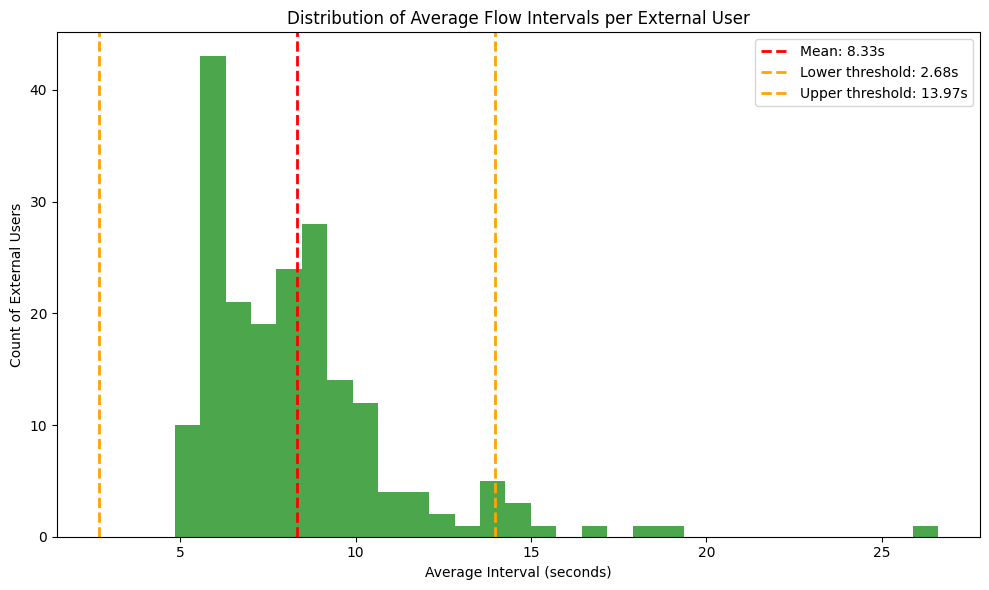

Alert: External users with anomalous interaction patterns with corporate public services:
       src_ip  num_flows  unique_servers  avg_interval
176.223.3.124        441               1     26.602568
176.223.3.127       2435               1     14.347654
176.223.3.152       1968               1     17.979720
176.223.3.163       1352               1     17.080859
 176.223.3.32       1188               1     15.474735
 176.223.3.38       1087               1     14.981390
 176.223.3.55       2223               1     14.615414
 176.223.3.80        989               1     18.673188


In [11]:
# Sort data by external client (src_ip) and timestamp, then compute time intervals between flows
servers = servers.sort_values(by=['src_ip', 'timestamp'])
servers['time_diff'] = servers.groupby('src_ip')['timestamp'].diff()

# For each external client (src_ip), compute summary statistics:
# - total flows (num_flows)
# - unique corporate servers contacted (unique_servers) – these servers are within the corporate public network (e.g., 200.0.0.0/24)
# - average time interval between successive flows (avg_interval)
external_summary = servers.groupby('src_ip').agg(
    num_flows=('src_ip', 'count'),
    unique_servers=('dst_ip', 'nunique'),
    avg_interval=('time_diff', 'mean')
).reset_index()

# Compute the overall mean and standard deviation of avg_interval among external users.
mean_interval = external_summary['avg_interval'].mean()
std_interval = external_summary['avg_interval'].std()

# Print baseline statistics for normal external user behavior
print("\nBaseline for External User Interaction Patterns:")
print(f"Total external users in baseline: {len(external_summary)}")
print(f"Average interval between flows (seconds): {mean_interval:.2f}")
print(f"Standard deviation of intervals: {std_interval:.2f}")
print(f"Lower threshold (mean - 2*std): {mean_interval - 2*std_interval:.2f}")
print(f"Upper threshold (mean + 2*std): {mean_interval + 2*std_interval:.2f}")

# Optional: Display histogram of average intervals to show the normal distribution
plt.figure(figsize=(10, 6))
plt.hist(external_summary['avg_interval'], bins=30, alpha=0.7, color='green')
plt.axvline(mean_interval, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_interval:.2f}s')
plt.axvline(mean_interval - 2*std_interval, color='orange', linestyle='dashed', linewidth=2, 
           label=f'Lower threshold: {mean_interval - 2*std_interval:.2f}s')
plt.axvline(mean_interval + 2*std_interval, color='orange', linestyle='dashed', linewidth=2,
           label=f'Upper threshold: {mean_interval + 2*std_interval:.2f}s')
plt.title('Distribution of Average Flow Intervals per External User')
plt.xlabel('Average Interval (seconds)')
plt.ylabel('Count of External Users')
plt.legend()
plt.tight_layout()
plt.show()

# Flag external users whose average interval deviates significantly (e.g., z-score > 2)
anomalous_external = external_summary[
    (external_summary['avg_interval'] < mean_interval - 2*std_interval) |
    (external_summary['avg_interval'] > mean_interval + 2*std_interval)
]

if not anomalous_external.empty:
    print("Alert: External users with anomalous interaction patterns with corporate public services:")
    print(anomalous_external.to_string(index=False))
else:
    print("No anomalous external user behavior detected in server accesses.")